Aim: 
Make easy-peasy non spatial random forest model
- Calibate model
- tune hyperparameters
- Evaluate performance

In [143]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt

from scipy import stats, optimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier # ,RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

import matplotlib.pyplot as plt
%matplotlib inline


In [144]:
df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_coords.xlsx")

df_candidates = gpd.GeoDataFrame(df_candidates, crs="EPSG:4326", geometry=gpd.points_from_xy(df_candidates.lat, df_candidates.lon))
df_candidates.tail(2)

,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_business,shp_damage_level_products,shp_closed_d,shp_duration_back2normal,contaminations,...,building_elevation_rel2surrounding,building_elevation_rel2surrounding.cm,shp_sector.specify,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_monetary_resources_prenvention,lat,lon,geometry,elevation
502,2.0,70.0,2.0,10,0.0,4,2,2,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,4.0
503,0.0,100.0,5.0,20,0.0,1,1,14,20,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,3.0


In [145]:
# ## remove businesses without direct damage costs

# df_candidates.Target_direct.value_counts();
# df_candidates = df_candidates[df_candidates.Target_direct > 0.0]  # 136=0.0
# print(df_candidates.shape)


## workaround due nan- cols from df_num or df_agg 
df_candidates = df_candidates[[c for c in df_candidates if df_candidates[c].isnull().sum() < 100]]
#df_candidates.isna().sum()
df_candidates = df_candidates.fillna(0)

In [146]:
y = df_candidates.Target_direct.astype("int64")
X = df_candidates.drop(["Target_direct",
                        #"shp_sector.specify",   # fix this variable and make as numerbs
                        #"Q0.1",
                        "geometry"#,"lat","lon"
                        ], axis=1)

# scaler = MinMaxScaler() 
# X = scaler.fit_transform(X_unscaled.reshape(-1, 1))


### Discretized continous variabels: 
E.g. by an equal frequency discretization
use coarse discrete classes for each varible e.g. 5 classes used in Can ho City-DS

In [147]:
#X['shp_sector.specify'] = X[''shp_sector.specify'].map({'no':0,'yes':1,'unknown':0})


### split into train and test set
- Normalization not needed, is optional


In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Train and tune model

In [150]:
model = RandomForestClassifier(bootstrap=True, oob_score=True)
model.fit(X_train, y_train)


RandomForestClassifier(oob_score=True)

In [151]:
### tunning of hyperparamters by RandomizedSearchCV
param_dist = {'n_estimators': [10, 100, 200, 500],
              'max_depth': [1, 3, 5, 10,20],
              #'min_impurity_decrease':  [0.1, 0.3 0.5],   # similar to early stopping = pevent overfitting
              }# randint(1, 20)}


In [152]:
randomized_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the model by randomizedSearchCV
randomized_search.fit(X_train, y_train)

## predict unseen X_test set
y_pred = model.predict(X_test)


c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few 

### Evaluation

In [153]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:  {accuracy*100:.2f}%")

Accuracy:  77.23%


In [154]:
## cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')


NameError: name 'RepeatedStratifiedKFold' is not defined

In [155]:
print(classification_report(y_test, y_pred))  


              precision    recall  f1-score   support

           0       0.86      0.97      0.91        59
           1       0.44      0.36      0.40        11
           2       0.50      0.40      0.44         5
           3       1.00      0.67      0.80         3
           4       0.67      0.67      0.67         3
           5       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
          10       0.40      0.67      0.50         3
          15       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         0
          20       1.00      0.67      0.80         3
          30       1.00      1.00      1.00         2
          40       1.00      1.00      1.00         2
          50       1.00      1.00      1.00         1
          70       0.00      0.00      0.00         0
          97       0.00      0.00      0.00         1
          99       0.00      0.00      0.00         2
         280       1.00    

c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\

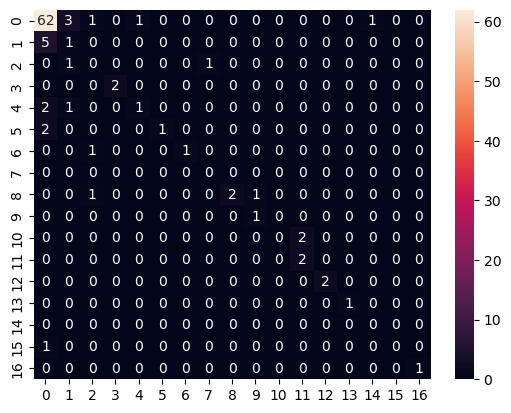

In [142]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

confusion_m =  confusion_matrix(y_test, y_pred)#, labels=["ant", "bird", "cat"])
#conf_mat = confusion_matrix(labels, predictions)

sns.heatmap(confusion_m, annot=True)
plt.show()


# disp = ConfusionMatrixDisplay.from_estimator( model,  X_test, y_test, 
#        display_labels=X_test.columns, cmap=plt.cm.Blues)
# disp.ax_.set_title("Confusion Matrix")
# print(disp.confusion_matrix)
# plt.show()


In [122]:
y_test.shape

(101,)

### Feautre importance

In [156]:
importances = model.feature_importances_
#importances = np.sort(importances)#[:10]

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances) #  reverse sort[::-1]


In [159]:
indices

array([ 8,  3,  9, 10,  6,  4,  2,  5,  7,  1,  0], dtype=int64)

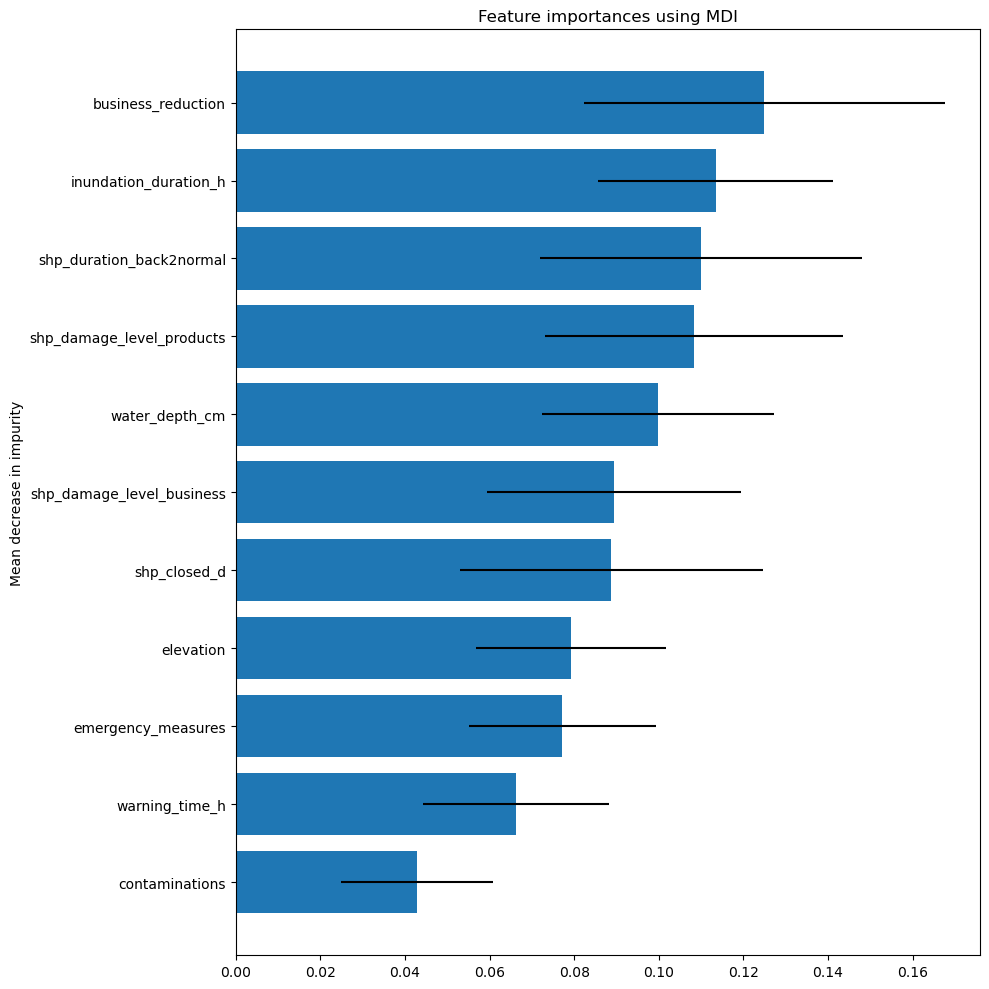

In [157]:
fig, ax = plt.subplots(figsize=(10,10))

plt.barh(range(len(indices)), importances[indices], align='center',  xerr=std[indices])
plt.yticks(range(len(indices)), np.array(X.columns)[indices])
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#  fig, ax = plt.subplots(figsize=(10,10))
# num_features = X.shape[1]
# forest_importances.plot.bar(range(X.shape[1]), importances[indices], yerr=std[indices]) # yerr=std, ax=ax,
# #forest_importances.plot.barh(range(X.shape[1]), importances[indices[-num_features:]], align='center')#,  yerr=std[indices])


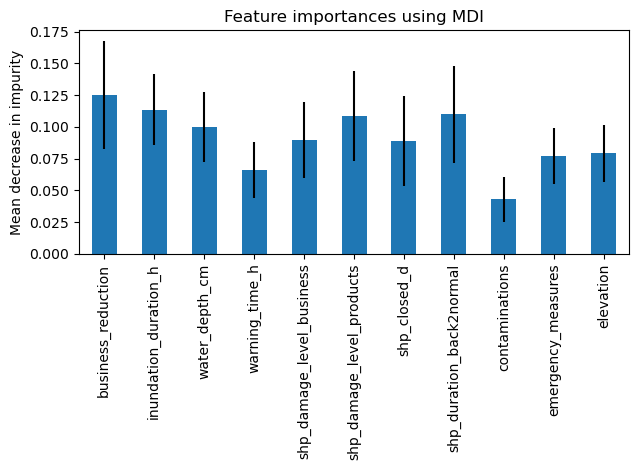

In [158]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()